In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import time
import sklearn.decomposition as skdec

import scipy
import sys
import os
from pytictoc import TicToc
import matplotlib
import h5py

from scipy.stats import gamma
from scipy.optimize import curve_fit
from scipy import optimize

sys.path.append('/home/moro/git_stuffs/SpeckledFluoImagingAnalisys/')
import speckle_stuffs as spkstf
from moro_utils import eprint


In [637]:
# def gamma_speckles(I, I0, scale, N):
#     return gamma.pdf(scale*I, N)*I0

def gamma_speckles(I, I0, scale, N):
    # introduce A and xscale since what is given will not be necessarly a pdf
    return gamma.pdf((I/I0), N)/(1/(I0*scale))

def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data, out_plot=False):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) - data)
    p, success = optimize.leastsq(errorfunction, params)
    if out_plot:
        plt.figure()
        plt.subplot(121)
        plt.imshow(data)
        plt.subplot(122)
        plt.imshow(gaussian(*p)(*np.indices(data.shape)))
    return p

def fit_speckle_statistics(frame, out_plot=True, out_fig='', bins = 40, central_crop = True):
    """fit the intensity statistics with a gamma distribution 
    and try to guess the independent speckles/degrees of freedom
    
    out_plot = bool : if set show the fits done for the analisys
    bins = int : set the binning used to calculate the distribution
    central_crop = bool : set the sigma of the gaussian fit to
                select as central part for the analisys of the frame
    """
#     if central_crop:
#         gopt = fitgaussian(frame)
# #         gaussian(*gopt)(*np.indices(frame.shape))
#         # now only a simple crop, later must implement a masked array 
#         # in the center with central simmetry
#         # RIGHT NOW GIVES WEIRD RESULTS CROPPING
#         x0 = int(gopt[1])
#         y0 = int(gopt[2])
#         xs = int(gopt[3]/2) must be tuned
#         ys = int(gopt[4]/2)must be tuned
#         frame = frame[x0-xs:x0+xs, y0-ys:y0+ys]
#         if out_plot:
#             plt.figure()
#             plt.imshow(frame)
#             plt.show()
    frame_contrast = np.std(frame)/np.mean(frame)
    N_contrast = 1/(frame_contrast**2)
#     N_contrast = 40
    print("contrast = %.7f, N = %d"%(frame_contrast, N_contrast))
    
    histogram = np.histogram(np.ravel(frame), bins)
    xxx = histogram[1][0:-1]+(histogram[1][1]-histogram[1][0])/2
    yyy = histogram[0]
    print(yyy)
    yyy = yyy/np.sum(yyy)
    print(yyy)

    errfunc = lambda p, x, y: gamma_speckles(x, *p) - y

    # set initial values for fit
#     p0 = [np.sum(frame)/(np.max(frame)*bins), 1/np.max(frame), N_contrast]
    # I0, xscale, N, A
#     p0 = [(np.max(frame)*bins)/np.sum(frame), 1/np.max(frame), N_contrast]
    scaling_factor = (np.max(frame)*bins)/np.sum(frame)
    print(1/scaling_factor)
#     p0 = [scaling_factor, 
#           np.max(frame),
#           N_contrast]
    p0 = [0.01, 
      100,
      N_contrast]

    popt, success= optimize.leastsq(errfunc, p0[:], args=(xxx, yyy))
    print("fit : N = %d, contrast = %.7f"%(popt[2],1/(np.sqrt(popt[2]))))
    if out_plot:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
        ax.plot(xxx, gamma_speckles(xxx,  *popt), 'r-')
#         ax.hist(np.ravel(frame), bins)
        ax.plot(xxx, yyy)
        ax.set_xlim([0,1])
        plt.show()
        if out_fig is not '':
            fig.savefig(out_fig, dpi=300)
    # return N from the fit
    return popt[2]

contrast = 0.1271238, N = 61
[    39    193    615   1228   1814   2298   3452   5736   9528  14509
  20127  27027  35655  48150  60101  73751  87173 102209 106387 109768
 109031 106446 104834  93236  79849  63773  47231  30735  18330  10712
   5656   3251   1624    878    419    180     91     28     17      5]
[2.81367823e-05 1.39240999e-04 4.43695413e-04 8.85947914e-04
 1.30872110e-03 1.65790579e-03 2.49046596e-03 4.13827136e-03
 6.87403235e-03 1.04676045e-02 1.45207440e-02 1.94987901e-02
 2.57235121e-02 3.47381043e-02 4.33602244e-02 5.32080982e-02
 6.28914800e-02 7.37392918e-02 7.67535348e-02 7.91927774e-02
 7.86610643e-02 7.67961007e-02 7.56331137e-02 6.72656675e-02
 5.76075366e-02 4.60094107e-02 3.40750863e-02 2.21739488e-02
 1.32242877e-02 7.72823620e-03 4.08055489e-03 2.34545331e-03
 1.17164447e-03 6.33438329e-04 3.02290045e-04 1.29862072e-04
 6.56524920e-05 2.02007668e-05 1.22647512e-05 3.60727978e-06]
22527.968663911848
fit : N = 61, contrast = 0.1272024


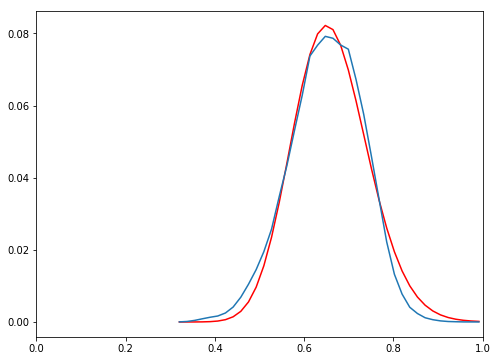

contrast = 0.1176037, N = 72
[     4     33    156    557   1616   3745   7803  12505  21539  31856
  43654  57647  76742  97389 117280 117825 135617 133004 124364 108986
  90425  70619  50949  34418  19592  13281   7257   3719   1859    903
    400    175     95     44     13      6      4      3      0      2]
[2.88582382e-06 2.38080465e-05 1.12547129e-04 4.01850967e-04
 1.16587282e-03 2.70185255e-03 5.62952082e-03 9.02180673e-03
 1.55394398e-02 2.29827009e-02 3.14944383e-02 4.15897715e-02
 5.53659730e-02 7.02618741e-02 8.46123545e-02 8.50055480e-02
 9.78416924e-02 9.59565279e-02 8.97231485e-02 7.86285988e-02
 6.52376548e-02 5.09484981e-02 3.67574595e-02 2.48310711e-02
 1.41347651e-02 9.58165655e-03 5.23560587e-03 2.68309470e-03
 1.34118662e-03 6.51474728e-04 2.88582382e-04 1.26254792e-04
 6.85383158e-05 3.17440621e-05 9.37892743e-06 4.32873574e-06
 2.88582382e-06 2.16436787e-06 0.00000000e+00 1.44291191e-06]
20808.98732283465
fit : N = 72, contrast = 0.1176103


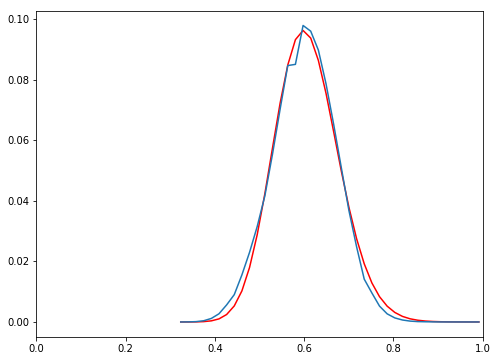

In [638]:
for i, idx in enumerate(idxs):
    frame = cut_vs[idx]
#     fig = plt.figure(figsize=(10,5))
#     ax = fig.add_subplot(1,2,1)
#     ax.imshow(frame, cmap='gray')
#     ax = fig.add_subplot(1,2,2)
#     plt.hist(np.ravel(frame),30)
    outimage = '/home/moro/ENS_owncloud/giganLab/papers/NMF_and_imaging/review_2/stat_%d.eps'%idx
    fit_speckle_statistics(frame/np.max(frame), central_crop=False, 
                           out_fig=outimage)
# plt.show()

0.0001201403970897054


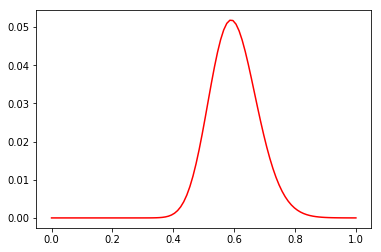

In [636]:
xxx = np.linspace(0,1,100)
# I0, scale, N
scaling_factor = (np.max(frame)*bins)/np.sum(frame)
print(scaling_factor)
N_contrast = 60
p0 = [0.01, 
      100,
      N_contrast]
plt.plot(xxx, gamma_speckles(xxx, *p0), 'r-')
plt.show()

In [572]:
xxx

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

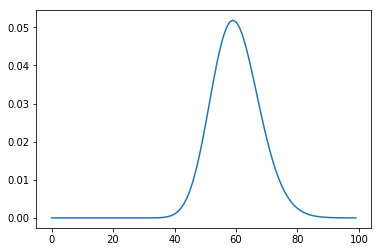

In [505]:
plt.plot(gamma.pdf(range(100), 60))
plt.show()

In [5]:
# supp figure 1
picklesource = '/home/moro/localdata/39519608500622/data_25012019_002_39519608500622_762875588588056.pickle' # fig 2
# picklesource = '/home/moro/localdata/154588749961840/data_23032019_all_154588749961840_1215868743061893.pickle' # fig 3

filehandler = open(picklesource, 'rb')
[extr_traces, extr_footprints, dpars] = pickle.load(filehandler)
filehandler.close()
videofile = '/home/moro/localdata/'+picklesource.split('/')[-1].split('_')[1] + os.sep+ '_'.join((picklesource.split('/')[-1]).split('_')[:3])+'.mat'
video_source = np.swapaxes(scipy.io.loadmat(videofile)['video_data'], 0, 2)

cannot import cuda libraries, filtering with the CPU...


cannot import cuda libraries, filtering with the CPU...
cannot import cuda libraries, filtering with the CPU...
cannot import cuda libraries, filtering with the CPU...
cannot import cuda libraries, filtering with the CPU...


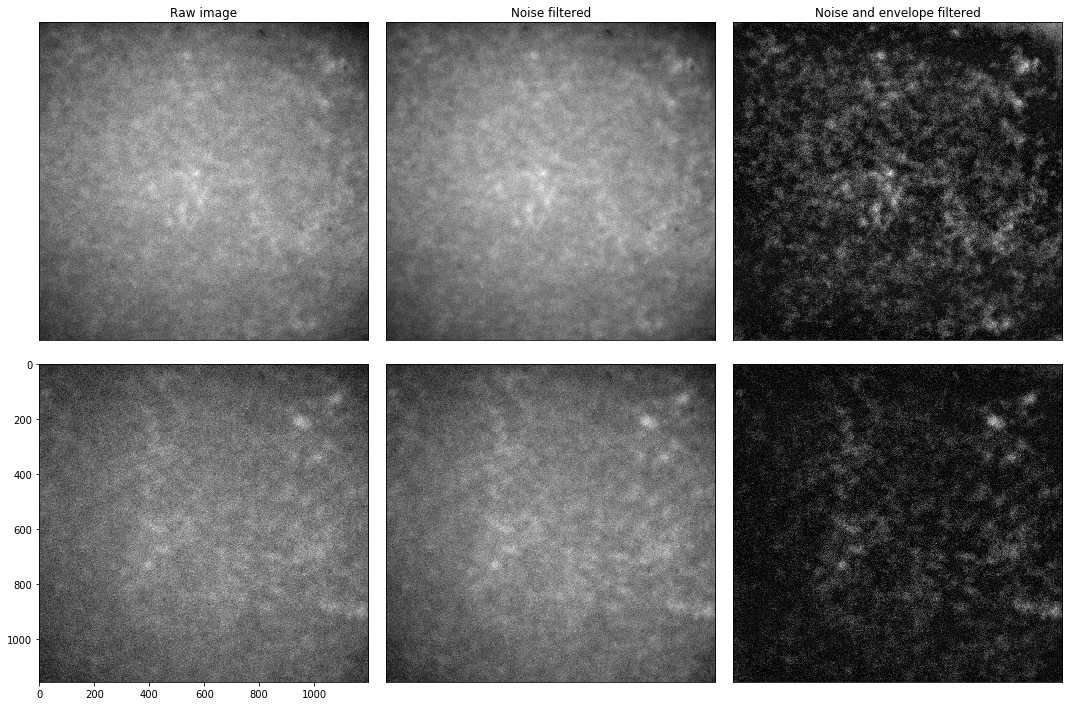

In [11]:
inde = 14
lp = dpars['lowfilter']
hp = dpars['highfilter']

cut_vs = video_source[-500:]
contrasts = np.array([spkstf.contrast(frame) for frame in cut_vs])
mn = np.mean(contrasts)
sd = np.std(contrasts)
# random choice of indexes
# idx = np.random.choice(np.where( np.logical_and((mn-sd) < contrasts, contrasts < (mn+sd)))[0], 1)[0]
# print(idx)

# idxs = [26, 29, 146, 499]
idxs = [29, 499]


fig = plt.figure(figsize=(15, 5*len(idxs)))

for i, idx in enumerate(idxs):
    ax = fig.add_subplot(len(idxs),3,1+i*3)
#     frame = spkstf.gauss_don_filt_GPU(cut_vs[idx])
    ax.grid(False)
    if i==0: ax.set_title('Raw image')
    if i!=(len(idxs)-1): 
        ax.set_xticks([])
        ax.set_yticks([])
    ax.imshow(cut_vs[idx], cmap='gray')

    ax = fig.add_subplot(len(idxs),3,2+i*3)
    frame = spkstf.gauss_don_filt_GPU(cut_vs[idx], lp=lp)
    ax.grid(False)
    if i==0: ax.set_title('Noise filtered')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(frame, cmap='gray')

    ax = fig.add_subplot(len(idxs),3,3+i*3)
    frame = spkstf.gauss_don_filt_GPU(cut_vs[idx], hp=hp, lp=lp)
    ax.grid(False)
    if i==0: ax.set_title('Noise and envelope filtered')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(frame, cmap='gray')

fig.tight_layout()
plt.show()

[357.91933062 568.30969303 369.25346874 507.27237967 493.04601769]
contrast = 0.281, N = 12
fit : N = 11, contrast = 0.291


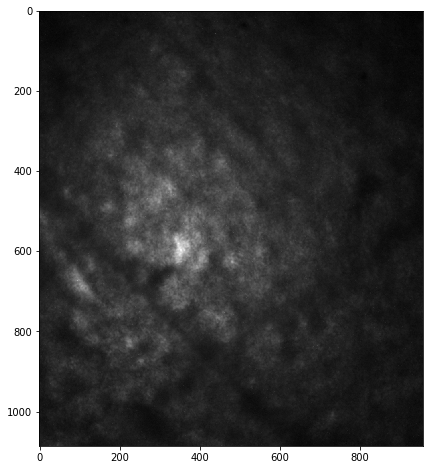

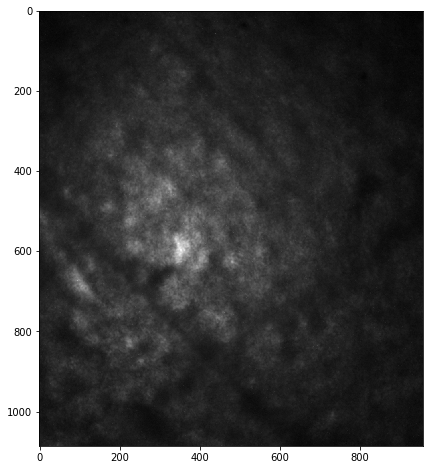

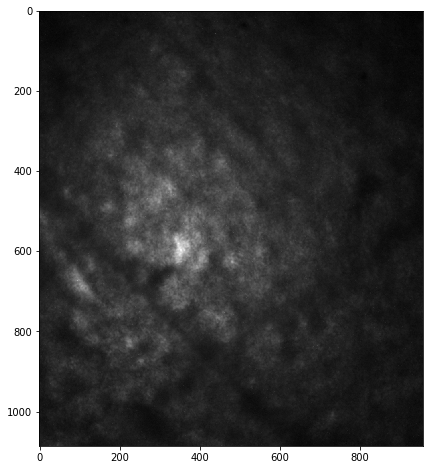

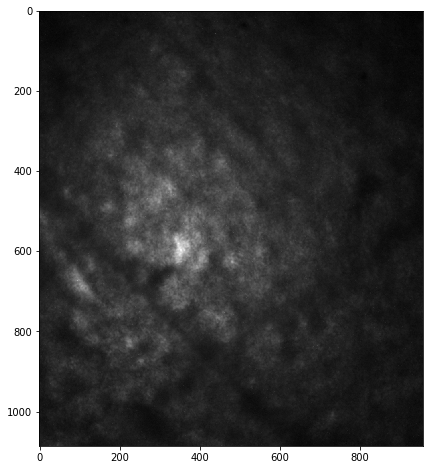

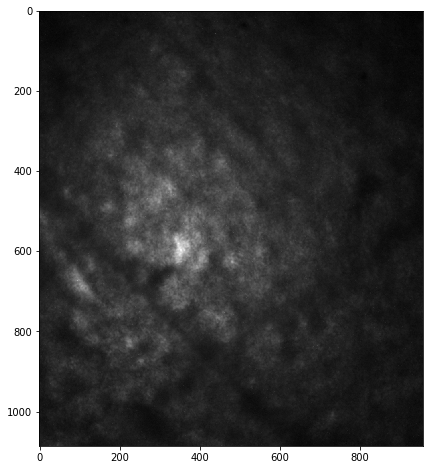

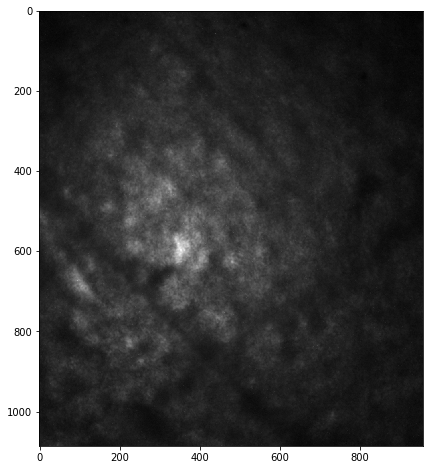

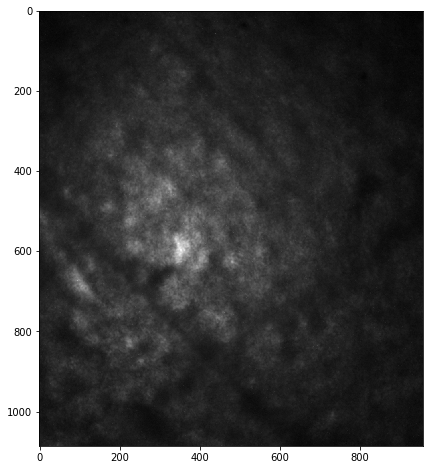

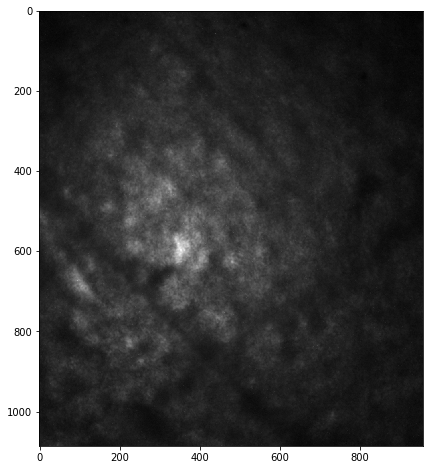

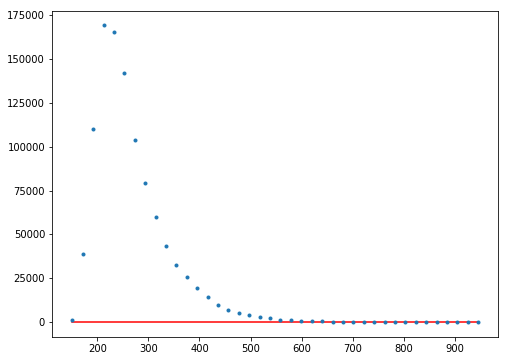

ValueError: too many values to unpack (expected 2)

In [315]:
# supp figure 13

root_folder = '/home/moro/localdata/20112019/'

video2000 = spkstf.extract_from_mat(root_folder+'data_20112019_001.mat', 'video_data')
video0000 = spkstf.extract_from_mat(root_folder+'data_20112019_003.mat', 'video_data')

fig = plt.figure(figsize=(16,8))

frameno = 40
plt.subplot(121)
frame = video0000[frameno]
plt.imshow(frame, cmap='gray')
fit_speckle_statistics(frame)

plt.subplot(122)
frame = video2000[frameno]
plt.imshow(np.mean(video2000, axis=0), cmap='gray')
fit_speckle_statistics(np.array(video2000))

plt.show()

## simulate multiple speckles and see the statistics

In [103]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import time

import sys
from pytictoc import TicToc

sys.path.append('.')
import speckle_stuffs as spkstf
from moro_utils import printProgressBar, show_video

# speckle version of NMF...not so different afterall...
from sklearn.decomposition import NMF

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


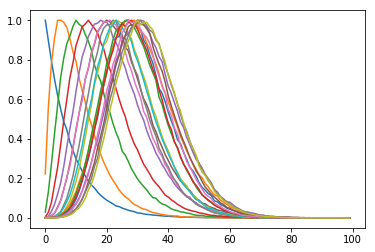

In [187]:
def speckle_stat(N):
    field_size = 512
    rpupil = 0.5
    bins = 100
    speckles = np.zeros((field_size, field_size))
    for idx in range(N):
        noise = np.random.rand(field_size, field_size)
        randomfield = np.ones_like(noise)*np.exp(1j*2*np.pi*noise)
        randomfield = spkstf.pupil(randomfield, rpupil)
        imagefield = np.fft.ifft2(randomfield)
        imageintensity = np.abs(imagefield)**2
        speckles = np.add(speckles, imageintensity)
    
    histogram = np.histogram(speckles, bins)
    yyy = histogram[0]/np.max(histogram[0])
    return histogram[1][1:], yyy

xxx, yyy = speckle_stat(iii, 512, 0.5, 100)
    plt.plot(yyy)
plt.show()

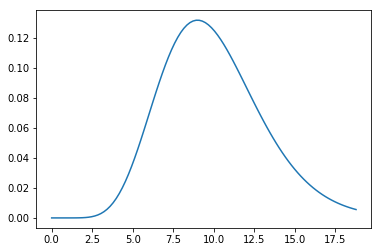

In [209]:
from scipy.stats import gamma
from scipy.optimize import curve_fit

popt, pcov = curve_fit(func, xdata, ydata)
plt.plot(xdata, func(xdata, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

N=10
x = np.linspace(0, gamma.ppf(0.99, N), 100)

plt.plot(x, gamma.pdf(x, N))
plt.show()